# Windows 10 Coin

train:  (row: 1,347,190, columns: 1,085)
test:   (row:   374,136, columns: 1,084)

y value: if HasClicked == True, app 1.8%

In [1]:
# Timer and file info
import math
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc # We're gonna be clearing memory a lot
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ml_metrics import mapk
from datetime import datetime
import re
from sklearn.metrics import matthews_corrcoef, f1_score, classification_report, confusion_matrix, precision_score, recall_score
%matplotlib inline

# Timer
class Timer:
    def __init__(self, text=None):
        self.text = text
        
    def __enter__(self):
        self.cpu = time.clock()
        self.time = time.time()
        if self.text:
            print("{}...".format(self.text))
            print(datetime.now())
        return self

    def __exit__(self, *args):
        self.cpu = time.clock() - self.cpu
        self.time = time.time() - self.time
        if self.text:
            print("%s: cpu %0.2f, time %0.2f\n" % (self.text, self.cpu, self.time))

In [2]:
def sample_train_holdout(_df, sample_count, holdout_count):   
    random.seed(7)
    sample_RowNumber = random.sample(list(_df['RowNumber']), (sample_count + holdout_count))
    train_RowNumber = random.sample(sample_RowNumber, sample_count)
    holdout_RowNumber = list(set(sample_RowNumber) - set(train_RowNumber))
    holdout = _df[_df['RowNumber'].isin(holdout_RowNumber)].copy()
    _df = _df[_df['RowNumber'].isin(train_RowNumber)]
    return _df, holdout 

In [3]:
# Change date column datetime type and extract date time features
def datetime_features(_df, _col, isDelete = False):
    # 1. For years greater than 2017, create year folder with regex and change year to 2017 in datetime column
    # find and return 4 digit number (1st finding) in dataframe string columns
    year_col = _col + 'Year'
    _df[year_col] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    years = sorted(list(_df[year_col].unique()))
    yearsGreaterThan2017 = sorted(i for i in years if i > 2017)

    # Two ways for strange year data (1) change it to 2017 temporarily (2) remove from data; we will go with (1)
    # because we cannot remove test rows anyway
    if isDelete:
        _df = _df[~_df[year_col].isin(yearsGreaterThan2017)]
    else:
        for i in yearsGreaterThan2017:
            print("replace ", i, " to 2017 for conversion")
            _df.loc[_df[year_col] == i, _col] = _df[_df[year_col] == i][_col].values[0].replace(str(i), "2017")
    
    # How to remove strange year rows
    # train = train[~train['year'].isin(yearsGreaterThan2017)]

    # 2. Convert string to datetime
    _df[_col] = pd.to_datetime(_df[_col])
    print(_col, "column conversion to datetime type is done")
    
    # 3. Add more date time features
    month_col = _col + 'Month'
    weekday_col = _col + 'Weekday'
    day_col = _col + 'Day'
    hour_col = _col + 'Hour'
    _df[month_col] = pd.DatetimeIndex(_df[_col]).month
    _df[weekday_col] = pd.DatetimeIndex(_df[_col]).weekday
    _df[day_col] = pd.DatetimeIndex(_df[_col]).day
    _df[hour_col] = pd.DatetimeIndex(_df[_col]).hour
    print("year, month, weekday, day, hour features are added")
    
    return _df

In [6]:
# feature engineering functions for dataframe

# Delete rows with list condition for dataframe
def delRows(_df, _col, _list):
    _df = _df[~_df[_col].isin(_list)]
    return _df

import re

# Create new column using regex pattern for strings for dataframe
def addFeatureRegex(_df, _col, _newCol):
    _df[_newCol] = _df[_col].apply(lambda x: int(re.findall(r"\D(\d{4})\D", " "+ str(x) +" ")[0]))
    return _df

# Convert string to datetime type
def stringToDatetime(_df, _col):
    _df[_col] = _df[_col].astype('datetime64[ns]')
    return _df

# Add features from datetime
def addDatetimeFeatures(_df, _col):
    _df[_col + 'Year'] = pd.DatetimeIndex(_df[_col]).year
    _df[_col + 'Month'] = pd.DatetimeIndex(_df[_col]).month
    _df[_col + 'Weekday'] = pd.DatetimeIndex(_df[_col]).weekday
    _df[_col + 'Day'] = pd.DatetimeIndex(_df[_col]).day
    _df[_col + 'Hour'] = pd.DatetimeIndex(_df[_col]).hour
    return _df

# Get categorical column names
def categoricalColumns(_df):
    cat_columns = _df.select_dtypes(['object']).columns
    print("Categorical column count:", len(cat_columns))
    print("First 5 values:", cat_columns[:5])
    return cat_columns

# Get column names starting with
def columnsStartingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.startswith(_str))
    print("Categorical column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get column names ending with
def columnsEndingWith(_df, _str):
    sorted_list = sorted(i for i in list(_df) if i.endswith(_str))
    print("Categorical column count:", len(sorted_list))
    print("First 5 values:", sorted_list[:5])    
    return sorted_list

# Get constant columns
def constantColumns(_df):
    constant_list = []
    cols = list(_df) # same as _df.columns.values
    for col in cols:
        if len(_df[col].unique()) == 1:
            constant_list.append(col)
    print("Constant column count:", len(constant_list))
    print("First 5 values:", constant_list[:5])  
    return constant_list

In [4]:
with Timer("Read train data..."):
    train = pd.read_csv('../input/CoinMlCompetitionSoftlandingTrainWithHeader.tsv', sep='\t') # (1347190, 1085)
    gc.collect()

Read train data......
2017-03-15 01:05:46.679201


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,8,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read train data...: cpu 102.60, time 102.61



In [7]:
# Get column groups and features
all_columns = list(train)
print("All columns:", len(all_columns))

# Remove constant columns for train (all included in time_ and days_ columns)
print("features without constant columns")
constant_columns = constantColumns(train)
features = list(set(all_columns) - set(constant_columns))
print("features:", len(features))

# With a lot of nulls, exclude first and check later for improvement
print("features without time_ and days_ columns")
time_columns = columnsStartingWith(train, 'Time_')
days_columns = columnsStartingWith(train, 'Days_')
features = list(set(features) - set(time_columns))
features = list(set(features) - set(days_columns))
print("features:", len(features))

All columns: 1085
features without constant columns
Constant column count: 60
First 5 values: ['Time_5319275a_whatsapp', 'Days_5319275a_whatsapp', 'Time_5b04b775_356b_4aa0_aaf8_6491ffea5602', 'Days_5b04b775_356b_4aa0_aaf8_6491ffea5602', 'Time_bo3submission']
features: 1025
features without time_ and days_ columns
Categorical column count: 517
First 5 values: ['Time_0c72c7cd_217379cb4ae6f', 'Time_0c72c7cd_beta', 'Time_123freesolitaire_exe', 'Time_1cv8_exe', 'Time_2345explorer_exe']
Categorical column count: 517
First 5 values: ['Days_0c72c7cd_217379cb4ae6f', 'Days_0c72c7cd_beta', 'Days_123freesolitaire_exe', 'Days_1cv8_exe', 'Days_2345explorer_exe']
features: 51


In [8]:
train.dtypes

RowNumber                                       int64
BubbleShownTime                                object
CampaignId                                     object
creativeName                                   object
UniqueUserDeviceKey                             int64
LifeTimeImpressionCount                       float64
LifeTimeConversionCount                       float64
RecentMonthConversionCount                    float64
IsVirtualDevice                                object
ISOCountryShortName                            object
FirstUpdatedDate                               object
DefaultInternetBrowser                         object
OSOOBEDateTime                                 object
ProcessorCores                                float64
ProcessorPhysicalCores                        float64
PrimaryDiskTotalCapacity                      float64
TotalPhysicalRAM                              float64
IsDomainJoined                                 object
IsCommercial                

In [9]:
with Timer("Read train data..."):
    print("train shape:", train.shape)

    datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
    for col in datetime_columns:
        print(col)
        if train[col].isnull().sum() > 0:
            train[col] = train[col].fillna('1/31/2017 11:40:18 AM')
        train = datetime_features(train, col, True)

    #train = stringToDatetime(train, 'OSOOBEDateTime')
    #train = addDatetimeFeatures(train, 'OSOOBEDateTime')

    print("train shape:", train.shape)

    gc.collect()

Read train data......
2017-03-15 01:12:26.936617
train shape: (1347190, 1085)
BubbleShownTime


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

BubbleShownTime column conversion to datetime type is done


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


year, month, day, hour features are added
FirstUpdatedDate
FirstUpdatedDate column conversion to datetime type is done
year, month, day, hour features are added
OSOOBEDateTime
OSOOBEDateTime column conversion to datetime type is done
year, month, day, hour features are added
train shape: (1347096, 1100)
Read train data...: cpu 677.44, time 677.44



In [11]:
train.head(1)

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,FirstUpdatedDateYear,FirstUpdatedDateMonth,FirstUpdatedDateWeekday,FirstUpdatedDateDay,FirstUpdatedDateHour,OSOOBEDateTimeYear,OSOOBEDateTimeMonth,OSOOBEDateTimeWeekday,OSOOBEDateTimeDay,OSOOBEDateTimeHour
0,1,2017-02-14 02:23:35,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,853972,1.0,0.0,0.0,False,Israel,...,2015,8,6,2,3,2016,10,0,31,16


In [16]:
cat_columns = train.select_dtypes(['object']).columns
for cat_column in cat_columns:
    print(cat_column)
    train[cat_column] = train[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()

CampaignId
creativeName
IsVirtualDevice
ISOCountryShortName
DefaultInternetBrowser
IsDomainJoined
IsAlwaysOnAlwaysConnectedCapable
DeviceTimezone
DisplayLanguage
GamerPCClassification
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus2
AppCategoryNMinus3
AppCategoryNMinus4
AppCategoryNMinus5
AppCategoryNMinus6
AppCategoryNMinus7
AppCategoryNMinus8


In [223]:
#train & test comp

# campaign id
print(len(X_train.CampaignId.unique())) # 333
print(len(test.CampaignId.unique()))    # 287  
print(len(list(set(X_train.CampaignId.unique()) - set(test.CampaignId.unique())))) # 61 <- try to remove these
print(len(list(set(test.CampaignId.unique()) - set(X_train.CampaignId.unique()))))

333
287
61
15


In [222]:
#train & test comp

# campaign id
print(len(X_train.UniqueUserDeviceKey.unique())) # 871174
print(len(test.UniqueUserDeviceKey.unique()))    # 289163  
len(list(set(X_train.UniqueUserDeviceKey.unique()) - set(test.UniqueUserDeviceKey.unique()))) # all, nobody in common

871174
289163


871174

In [36]:
#pd.DataFrame({'count' : df_ad_lt_n.groupby( [ "ad_count", "click_rate"] ).size()}).reset_index()
user_campaign_click_count = pd.DataFrame({'count': train[train.HasClicked == 1].groupby(['CampaignId', 'UniqueUserDeviceKey']).size()}).reset_index()
# 22461

user_campaign_click_count['CampaignUser'] = user_campaign_click_count['CampaignId'].astype(str).str.cat(user_campaign_click_count['UniqueUserDeviceKey'].astype(str), sep='_')
# train count = count -1 to remove self
# test count = count

In [37]:
len(user_campaign_click_count)

22461

In [39]:
user_campaign_click_dict = dict([(i, a) for i, a in zip(user_campaign_click_count['CampaignUser'], user_campaign_click_count['count'])])

In [45]:
user_campaign_click_dict['2000000000266460' + '_' + '444443']

4

In [47]:
train['CampaignUser'] = train['CampaignId'].astype(str).str.cat(train['UniqueUserDeviceKey'].astype(str), sep='_')
train['click_count'] = train['CampaignUser'].apply(lambda x: user_campaign_click_dict[x] if x in user_campaign_click_dict else 0)

In [62]:
cols = ['CampaignUser', 'click_count', 'HasClicked']
#train[train.click_count ==1]
print(train[train.click_count > 0][cols].head(20))
train['CampaignUserClickCountBeforeOrAfter'] = train['click_count'] - train['HasClicked']

                    CampaignUser  click_count HasClicked
658     15000000000265856_370653            1       True
659     15000000000265856_370652            1       True
1274    61000000000271508_212157            1       True
1787   89000000000268322_1082885            1       True
2268   89000000000268322_1130405            1       True
2509  111000000000270254_1013436            1       True
2807    38000000000269970_699622            1       True
3353     3000000000265650_402587            1       True
3602   111000000000270254_264941            1       True
3993  111000000000270254_1183834            1       True
4235  111000000000270254_1109486            4       True
4236  111000000000270254_1109486            4       True
4237  111000000000270254_1109486            4       True
4238  111000000000270254_1109486            4       True
4733    61000000000271508_885942            1       True
5273   110000000000260682_567534            1       True
5524    3000000000265650_120508

In [64]:
train[train.click_count > 0]['CampaignUserClickCountBeforeOrAfter']

658        0
659        0
1274       0
1787       0
2268       0
2509       0
2807       0
3353       0
3602       0
3993       0
4235       3
4236       3
4237       3
4238       3
4733       0
5273       0
5524       0
5735       0
5768       0
6767       0
8356       0
8657       0
8686       0
8800       0
8828       3
8829       2
8830       2
8831       3
8832       2
8833       3
          ..
1345685    0
1345686    0
1345738    1
1345739    1
1345740    0
1345807    0
1345916    0
1345992    0
1346023    0
1346055    0
1346060    0
1346122    0
1346212    0
1346213    0
1346283    0
1346414    0
1346469    0
1346475    1
1346476    1
1346587    0
1346590    0
1346624    0
1346656    0
1346703    0
1346721    0
1346788    0
1346936    0
1347013    0
1347092    0
1347094    0
Name: CampaignUserClickCountBeforeOrAfter, dtype: int64

In [38]:
user_campaign_click_count[user_campaign_click_count['count'] > 1] # 1695

,CampaignId,UniqueUserDeviceKey,count,CampaignUser
36,2000000000266440,322165,2,2000000000266440_322165
46,2000000000266440,417754,2,2000000000266440_417754
68,2000000000266440,670178,2,2000000000266440_670178
74,2000000000266440,759086,2,2000000000266440_759086
102,2000000000266440,960222,2,2000000000266440_960222
148,2000000000266460,34762,2,2000000000266460_34762
151,2000000000266460,36574,2,2000000000266460_36574
207,2000000000266460,136403,2,2000000000266460_136403
277,2000000000266460,266398,2,2000000000266460_266398
281,2000000000266460,272385,2,2000000000266460_272385


In [65]:
features

['HasRearFacingCamera',
 'RecentMonthConversionCount',
 'IsPenCapable',
 'IsMalware',
 'NumberofExternalDisplays',
 'DefaultInternetBrowser',
 'FrontFacingCameraResolution',
 'AppCategoryNMinus1',
 'GamerSegment',
 'GamerPCClassification',
 'UniqueUserDeviceKey',
 'IsVirtualDevice',
 'NumberofInternalDisplays',
 'IsDomainJoined',
 'FirstUpdatedDate',
 'AppCategoryNMinus4',
 'TotalPhysicalRAM',
 'OSOOBEDateTime',
 'HasClicked',
 'ProcessorPhysicalCores',
 'AppCategoryNMinus6',
 'ProcessorClockSpeed',
 'HasFrontFacingCamera',
 'InternalPrimaryDisplayLogicalDPIY',
 'ProcessorCores',
 'InternalPrimaryDisplayResolutionVertical',
 'AppCategoryNMinus3',
 'TotalEngagementTimeInSec',
 'creativeName',
 'IsTouchEnabled',
 'AppCategoryNMinus8',
 'BubbleShownTime',
 'TotalDays',
 'IsAlwaysOnAlwaysConnectedCapable',
 'DeviceTimezone',
 'LifeTimeImpressionCount',
 'IsCommercial',
 'IsEducation',
 'AppCategoryNMinus2',
 'AppCategoryNMinus5',
 'AppCategoryNMinus7',
 'DisplayLanguage',
 'CampaignId',
 '

In [14]:
print(train.IsVirtualDevice.unique())
print(train.IsVirtualDevice.mean())
print(train.IsVirtualDevice.isnull().sum())

[False True nan]
0.0151771033223
1


In [608]:
features = list(set(features) - set(['RowNumber', 'BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime', 'HasClicked']))

In [607]:
train[features].dtypes

DefaultInternetBrowser                                 int64
IsPenCapable                                            bool
AppCategoryNMinus4                                     int64
InternalPrimaryDisplayResolutionVertical             float64
IsVirtualDevice                                        int64
IsEducation                                             bool
OSOOBEDateTime                                datetime64[ns]
TotalEngagementTimeInSec                             float64
creativeName                                           int64
InternalPrimaryDisplayLogicalDPIX                    float64
IsCommercial                                            bool
IsAlwaysOnAlwaysConnectedCapable                       int64
InternalPrimaryDisplayLogicalDPIY                    float64
CampaignId                                             int64
ProcessorClockSpeed                                  float64
AppCategoryNMinus8                                     int64
InternalPrimaryDiagonalD

In [545]:
with Timer("Sampling with holdout..."):
    train, holdout = sample_train_holdout(train, sample_count = 300000, holdout_count = 100000)
   
    print(train.shape)
    print(holdout.shape)
    
    gc.collect()

Sampling with holdout......
2017-03-14 14:41:12.431509
(300000, 1085)
(100000, 1085)
Sampling with holdout...: cpu 6.16, time 6.16



In [548]:
print(len(train.creativeName.unique()))
print(len(train.CampaignId.unique()))

143
285


In [447]:
train.shape

(199983, 1097)

In [351]:
train.head(1)

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,Days_Games_Casual,HasClicked,BubbleShownTimeYear,BubbleShownTimeMonth,BubbleShownTimeDay,BubbleShownTimeHour,FirstUpdatedDateYear,FirstUpdatedDateMonth,FirstUpdatedDateDay,FirstUpdatedDateHour
0,1,2017-02-14 02:23:35,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,853972,1.0,0.0,0.0,False,Israel,...,NaN,False,2017,2,14,2,2015,8,2,3


In [399]:
cat_columns = train.select_dtypes(['object']).columns
imp_columns = ['CampaignId', 'creativeName', 'UniqueUserDeviceKey', 'LifeTimeImpressionCount', 
               'LifeTimeConversionCount', 'RecentMonthConversionCount', 'ISOCountryShortName',
               'DisplayLanguage', 'DeviceTimezone', 'HasClicked']

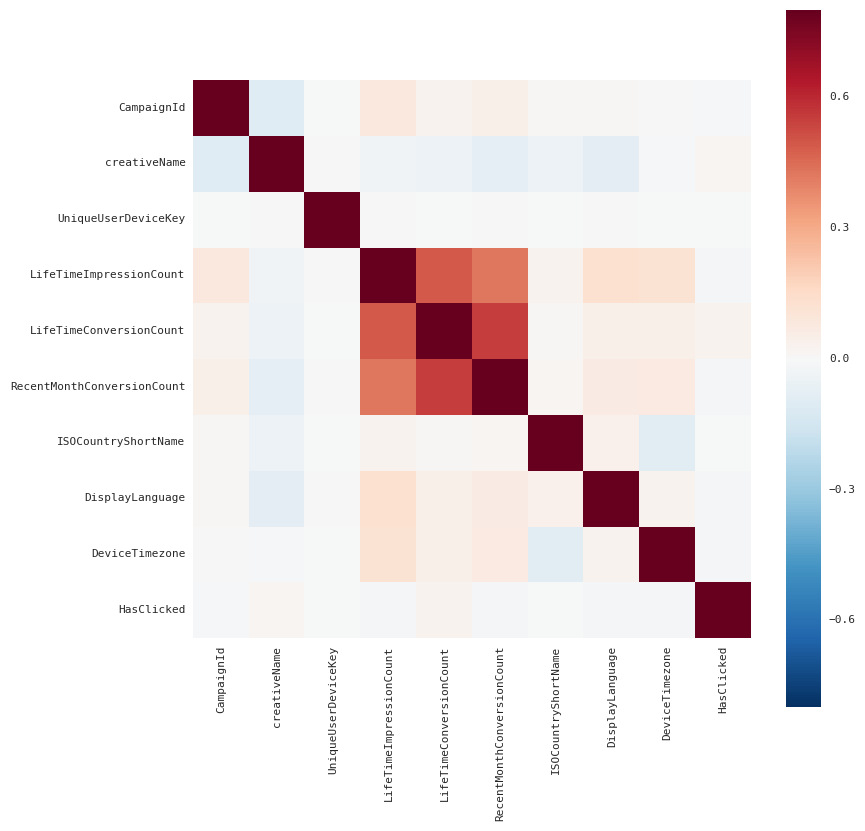

In [400]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="paper", font="monospace")

# Load the datset of correlations between cortical brain networks
#df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)
corrmat = train[imp_columns].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)

In [393]:
print(len(train.CampaignId.unique()))
print(len(train.creativeName.unique()))

267
135


In [344]:
train[cat_columns].head(1)

,BubbleShownTime,CampaignId,creativeName,IsVirtualDevice,ISOCountryShortName,FirstUpdatedDate,DefaultInternetBrowser,OSOOBEDateTime,IsDomainJoined,IsAlwaysOnAlwaysConnectedCapable,...,GamerPCClassification,GamerSegment,AppCategoryNMinus1,AppCategoryNMinus2,AppCategoryNMinus3,AppCategoryNMinus4,AppCategoryNMinus5,AppCategoryNMinus6,AppCategoryNMinus7,AppCategoryNMinus8
0,2/14/2017 2:23:35 AM,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,False,Israel,8/2/2015 3:55:20 AM,Chrome,10/31/2016 4:07:21 PM,False,False,...,Gen7,GamingOtherHardware.UpTo7DaysGaming.DX12Integr...,Browser,Browser,Browser,Utilities & Tools:Downloader,Media:AV Player,Comm & Collab,Browser,Comm & Collab


In [345]:
date_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']

In [355]:
with Timer("Read train data..."):
    #for col in date_columns:
    train = datetime_features(train, 'BubbleShownTime', isDelete = True)
    train = datetime_features(train, 'FirstUpdatedDate', isDelete = True)
    train['OSOOBEDateTime'] = pd.to_datetime(train['OSOOBEDateTime'])
    train['OSOOBEDateTimeYear'] = pd.DatetimeIndex(train['OSOOBEDateTime']).year
    train['OSOOBEDateTimeMonth'] = pd.DatetimeIndex(train['OSOOBEDateTime']).month
    train['OSOOBEDateTimeDay'] = pd.DatetimeIndex(train['OSOOBEDateTime']).day
    train['OSOOBEDateTimeHour'] = pd.DatetimeIndex(train['OSOOBEDateTime']).hour
    gc.collect()

Read train data......
2017-03-13 13:25:06.347639
Read train data...: cpu 30.73, time 30.72



In [66]:
train.dtypes

RowNumber                                              int64
BubbleShownTime                               datetime64[ns]
CampaignId                                             int64
creativeName                                           int64
UniqueUserDeviceKey                                    int64
LifeTimeImpressionCount                              float64
LifeTimeConversionCount                              float64
RecentMonthConversionCount                           float64
IsVirtualDevice                                        int64
ISOCountryShortName                                    int64
FirstUpdatedDate                              datetime64[ns]
DefaultInternetBrowser                                 int64
OSOOBEDateTime                                datetime64[ns]
ProcessorCores                                       float64
ProcessorPhysicalCores                               float64
PrimaryDiskTotalCapacity                             float64
TotalPhysicalRAM        

In [357]:
cat_columns = train.select_dtypes(['object']).columns
for cat_column in cat_columns:
    print(cat_column)
    train[cat_column] = train[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()

CampaignId
creativeName
IsVirtualDevice
ISOCountryShortName
DefaultInternetBrowser
IsDomainJoined
IsAlwaysOnAlwaysConnectedCapable
DeviceTimezone
DisplayLanguage
GamerPCClassification
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus2
AppCategoryNMinus3
AppCategoryNMinus4
AppCategoryNMinus5
AppCategoryNMinus6
AppCategoryNMinus7
AppCategoryNMinus8


In [137]:
with Timer("Replace missing value with -1..."):
    train = train.fillna(-1)

Replace missing value with -1......
2017-03-15 08:42:18.887886
Replace missing value with -1...: cpu 13.14, time 13.14



In [389]:
print("UniqueUserDeviceKey length:", len(train.UniqueUserDeviceKey.unique()))
print(train.UniqueUserDeviceKey.value_counts())

User_count = train.groupby('UniqueUserDeviceKey')['HasClicked'].count()
clicked_user_count = train.groupby('UniqueUserDeviceKey')['HasClicked'].sum()
print(len(clicked_user_count[clicked_user_count > 1]))
print(clicked_user_count[clicked_user_count > 1])

UniqueUserDeviceKey length: 191531
881948     5
1146376    5
671180     5
966405     4
1138611    4
309975     4
884103     4
705840     4
306675     4
468636     4
143927     4
441063     4
36353      4
261747     4
908584     4
814505     4
1058887    4
207496     3
851408     3
1005581    3
895649     3
743907     3
959834     3
1041563    3
1090988    3
450444     3
835261     3
696058     3
1035643    3
1076287    3
          ..
603075     1
1110751    1
436865     1
696960     1
470128     1
1002059    1
344700     1
680600     1
1058235    1
1196700    1
785067     1
25017      1
203447     1
463542     1
215414     1
473779     1
207537     1
1034925    1
842454     1
1307306    1
1203680    1
780969     1
351152     1
758438     1
1018533    1
135682     1
238240     1
1252124    1
676510     1
800263     1
Name: UniqueUserDeviceKey, dtype: int64
103
UniqueUserDeviceKey
632        2.0
9799       2.0
34724      2.0
65078      2.0
83806      2.0
95628      3.0
115135     2.0
120

In [667]:
print(train.UniqueUserDeviceKey.unique())

NameError: name 'train' is not defined

In [381]:
train.head()

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,BubbleShownTimeDay,BubbleShownTimeHour,FirstUpdatedDateYear,FirstUpdatedDateMonth,FirstUpdatedDateDay,FirstUpdatedDateHour,OSOOBEDateTimeYear,OSOOBEDateTimeMonth,OSOOBEDateTimeDay,OSOOBEDateTimeHour
0,1,2017-02-14 02:23:35,3000000000265650,845798958437479683,853972,1.0,0.0,0.0,0,7490503256446548118,...,14,2,2015,8,2,3,2016.0,10.0,31.0,16.0
4,5,2017-02-14 21:25:06,111000000000270254,410887359715240345,228110,3.0,0.0,0.0,0,1812587964233986913,...,14,21,2015,8,17,22,2017.0,1.0,21.0,0.0
6,7,2017-02-11 13:21:00,3000000000265412,1358208763371339792,79974,22.0,0.0,0.0,0,4014849792457859739,...,11,13,2015,8,5,3,2016.0,10.0,9.0,4.0
8,9,2017-02-12 20:46:26,3000000000265650,845798958437479683,79974,22.0,0.0,0.0,0,4014849792457859739,...,12,20,2015,8,5,3,2016.0,10.0,9.0,4.0
19,20,2017-02-14 04:18:48,111000000000270254,410887359715240345,636220,28.0,0.0,0.0,0,4014849792457859739,...,14,4,2015,9,2,3,2016.0,10.0,24.0,23.0


In [67]:
train_y = train['HasClicked'].values
#train.drop('HasClicked', axis = 1, inplace = True)
#train.drop('RowNumber', axis = 1, inplace = True)
#train.drop('BubbleShownTime', axis = 1, inplace = True)
train_y.mean()

0.018306045003474141

In [361]:
#features = train.columns

In [112]:
all_columns = list(train)

In [113]:
drop_features = ['HasClicked', 'RowNumber', 'BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime', 
                 'CampaignUser', 'click_count', 'CampaignUserClickCountBeforeOrAfter']

In [166]:
features = list(set(all_columns) - set(constant_columns))
features = list(set(features) - set(time_columns))
features = list(set(features) - set(days_columns))
features = list(set(features) - set(drop_features))

In [167]:
features

['HasRearFacingCamera',
 'RecentMonthConversionCount',
 'IsPenCapable',
 'IsMalware',
 'OSOOBEDateTimeMonth',
 'GamerSegment',
 'AppCategoryNMinus1',
 'GamerPCClassification',
 'UniqueUserDeviceKey',
 'AppCategoryNMinus4',
 'TotalPhysicalRAM',
 'OSOOBEDateTimeYear',
 'ProcessorClockSpeed',
 'InternalPrimaryDisplayLogicalDPIY',
 'FirstUpdatedDateYear',
 'ProcessorCores',
 'TotalEngagementTimeInSec',
 'BubbleShownTimeMonth',
 'AppCategoryNMinus8',
 'TotalDays',
 'IsAlwaysOnAlwaysConnectedCapable',
 'OSOOBEDateTimeDay',
 'DeviceTimezone',
 'IsCommercial',
 'AppCategoryNMinus2',
 'FirstUpdatedDateWeekday',
 'OSOOBEDateTimeWeekday',
 'InternalPrimaryDisplayResolutionHorizontal',
 'CampaignId',
 'LifeTimeConversionCount',
 'FirstUpdatedDateHour',
 'FirstUpdatedDateDay',
 'NumberofExternalDisplays',
 'DefaultInternetBrowser',
 'FrontFacingCameraResolution',
 'NumberofInternalDisplays',
 'IsVirtualDevice',
 'IsDomainJoined',
 'BubbleShownTimeYear',
 'ProcessorPhysicalCores',
 'AppCategoryNMinu

In [118]:
print(len(X_train.CampaignId.unique()))
print(len(X_train.creativeName.unique()))
print(len(X_train.UniqueUserDeviceKey.unique()))

333
158
871174


In [141]:
from sklearn.model_selection import train_test_split
with Timer('# train validation split'):
    X_train, X_val, y_train, y_val = train_test_split(train[features], train_y, test_size=0.2, random_state=0)

# train validation split...
2017-03-15 08:49:12.597943
# train validation split: cpu 27.88, time 27.88



In [146]:
gc.collect()

print(y_train.shape)
print(X_train.shape)
print(y_val.shape)
print(X_val.shape)

(1077676,)
(1077676, 1035)
(269420,)
(269420, 1035)


In [147]:
#del train
gc.collect()

16

In [174]:
X_train[features].shape

(1077676, 61)

In [168]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train[features], label=y_train)
val_data = lgb.Dataset(X_val[features], y_val)

In [200]:
params = {
    'task' : 'train',
    'boosting_type' : 'dart', #'gbdt', # dart
    'objective' : 'binary',
    'metric' : 'auc', #'binary_logloss', # binary_logloss, auc
    'is_training_metric': True,
    'max_bin': 255,
    'num_leaves' : 64,
    'learning_rate' : 0.02, #0.05, #0.1,
    'feature_fraction' : 0.8,
    'min_data_in_leaf': 10,
    'min_sum_hessian_in_leaf': 5,
    # 'num_threads': 16,
}
num_round = 5000



In [201]:
bst = lgb.train(params, train_data, num_round, valid_sets=val_data, early_stopping_rounds=5)

# valid_0's logloss:0.0844732 LB: 0.097603
# valid_0's logloss:0.0744244 (test does not have UserCampaignClickBeforeOrAfter - check further)
#[466]	valid_0's logloss:0.0838359 with null value - strange result in val
#[277]	valid_0's logloss:0.0840156

# binary, auc, [1802]	valid_0's auc:0.700541
# regression, auc [282]	valid_0's auc:0.686718, f1 local: 0.110575205431, 

[1]	valid_0's auc:0.627206
Train until valid scores didn't improve in 5 rounds.
[2]	valid_0's auc:0.631792
[3]	valid_0's auc:0.634586
[4]	valid_0's auc:0.636439
[5]	valid_0's auc:0.637919
[6]	valid_0's auc:0.638444
[7]	valid_0's auc:0.639213
[8]	valid_0's auc:0.639819
[9]	valid_0's auc:0.642139
[10]	valid_0's auc:0.643313
[11]	valid_0's auc:0.644286
[12]	valid_0's auc:0.644895
[13]	valid_0's auc:0.645423
[14]	valid_0's auc:0.64639
[15]	valid_0's auc:0.646976
[16]	valid_0's auc:0.64767
[17]	valid_0's auc:0.648418
[18]	valid_0's auc:0.648887
[19]	valid_0's auc:0.649438
[20]	valid_0's auc:0.650557
[21]	valid_0's auc:0.650992
[22]	valid_0's auc:0.651453
[23]	valid_0's auc:0.651645
[24]	valid_0's auc:0.651994
[25]	valid_0's auc:0.652606
[26]	valid_0's auc:0.652814
[27]	valid_0's auc:0.653032
[28]	valid_0's auc:0.653174
[29]	valid_0's auc:0.653637
[30]	valid_0's auc:0.653966
[31]	valid_0's auc:0.654428
[32]	valid_0's auc:0.655061
[33]	valid_0's auc:0.655155
[34]	valid_0's auc:0.655321
[35]	v

In [202]:
with Timer('# predict validation data'):
    val_preds = bst.predict(X_val[features], num_iteration=bst.best_iteration)

# predict validation data...
2017-03-15 18:21:24.555950
# predict validation data: cpu 47.87, time 47.88



In [203]:
X_val[features].shape

(269420, 61)

In [204]:
X_train[features].head(1)

,HasRearFacingCamera,RecentMonthConversionCount,IsPenCapable,IsMalware,OSOOBEDateTimeMonth,GamerSegment,AppCategoryNMinus1,GamerPCClassification,UniqueUserDeviceKey,AppCategoryNMinus4,...,AppCategoryNMinus5,AppCategoryNMinus7,DisplayLanguage,FirstUpdatedDateMonth,BubbleShownTimeDay,InternalPrimaryDisplayLogicalDPIX,InternalPrimaryDiagonalDisplaySizeInInches,ISOCountryShortName,InternalBatteryNumberOfCharges,PrimaryDiskTotalCapacity
1062215,False,0.0,False,-1.0,8,8703880559801793403,8445571620793378284,5911611747197843247,1251896,8445571620793378284,...,8445571620793378284,8445571620793378284,1836577960071098331,7,14,96.0,23.0,7744898935916903603,-1.0,476940.0


In [205]:
val_preds

array([ 0.00885297,  0.00823979,  0.02731615, ...,  0.00890272,
        0.02024455,  0.00878073], dtype=float32)

In [156]:
def bestF1Threshold(_y_true, _y_preds, _steps = 100):
    #Find the best threshold (epsilon) to use for selecting outliers
    bestEpsilon = 0
    bestF1 = 0
    bestPrecision = 0
    bestRecall = 0
    F1 = 0

    pval = _y_preds
    yval = _y_true

    stepsize = (max(pval) - min(pval)) / _steps
    print("stepsize:",stepsize)
    print("min:", min(pval))
    print("max:", max(pval))

    #for i in np.arange(0.1, 0.5, 0.01):
    #    print(i)

    for epsilon in np.arange(min(pval), max(pval), stepsize):
    #for epsilon in np.arange(0.02, 0.06, 0.001):
        #print(epsilon)
        predictions = pval > epsilon;
        true_positives = sum((predictions == 1) & (yval == 1))
        false_positives = sum((predictions == 1) & (yval == 0))
        false_negatives = sum((predictions == 0) & (yval == 1))
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        F1 = (2 * (precision * recall)) / (precision + recall)
        #print(epsilon, F1)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            bestPrecision = precision
            bestRecall = recall

    print("bestF1:", bestF1)
    print("bestEpsilon:", bestEpsilon)
    print("bestPrecision:", bestPrecision)
    print("bestRecall:", bestRecall)
    
    return bestF1, bestEpsilon

In [207]:
bestF1, bestEpsilon = bestF1Threshold(y_val, val_preds, 500)

stepsize: 0.00141545701027
min: 0.00407734
max: 0.711806


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: RuntimeWarning: invalid value encountered in double_scalars


bestF1: 0.120091533181
bestEpsilon: 0.0522028802224
bestPrecision: 0.107664533071
bestRecall: 0.135761589404


0.119970738844
0.0521821821822


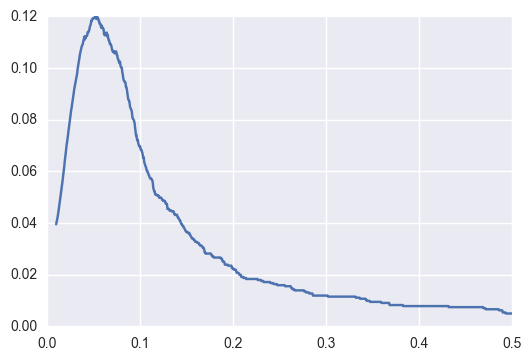

In [206]:
thresholds = np.linspace(0.01, 0.5, 1000)
fc = np.array([f1_score(y_val, val_preds>thr) for thr in thresholds])
plt.plot(thresholds, fc)
best_threshold = thresholds[fc.argmax()]
print(fc.max())
print(best_threshold)

# binary, binary_logloss, 0.123654933431, 0.0551251251251
# binary, auc, 0.0976362602551, 0.0585585585586, lr: 0.05
# regression, auc, 0.110575205431, 0.059049049049
# binary, auc, 0.119970738844, 0.0521821821822, lr: 0.02

0.391267355775
0.484304304304


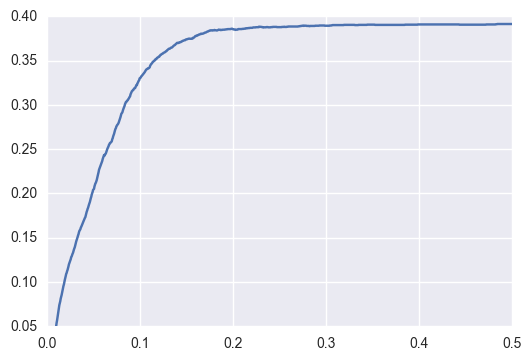

In [84]:
thresholds = np.linspace(0.01, 0.5, 1000)
mcc = np.array([matthews_corrcoef(y_val, val_preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold_mcc = thresholds[mcc.argmax()]
print(mcc.max())
print(best_threshold_mcc)

In [313]:
bool_preds = np.repeat(False, len(val_preds))
for i, pred in enumerate(val_preds):
    if pred >= 0.0423582170084: #0.045 #0.06
        bool_preds[i] = True

print(bool_preds.mean())

y_true = y_val
y_pred = bool_preds

print("precision: ", precision_score(y_true, y_pred))
print("recall: ", recall_score(y_true, y_pred))

print("TP: ", sum((y_true == 1) & (y_pred == 1)))
print("FP: ", sum((y_true == 0) & (y_pred == 1)))
print("TN: ", sum((y_true == 0) & (y_pred == 0)))
print("FN: ", sum((y_true == 1) & (y_pred == 0)))

print(confusion_matrix(y_true, y_pred))
print("f1_score: %f" % f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

# logloss: 0.08679, threshold: 0.0531, fl: 0.071873

0.0292
precision:  0.0616438356164
recall:  0.100840336134
TP:  72
FP:  1096
TN:  38190
FN:  642
[[38190  1096]
 [  642    72]]
f1_score: 0.076514
             precision    recall  f1-score   support

      False       0.98      0.97      0.98     39286
       True       0.06      0.10      0.08       714

avg / total       0.97      0.96      0.96     40000



In [208]:
bst.feature_importance()

array([  47,  381,  172,  269, 2095, 3248, 2137,  892, 6201, 1646, 1569,
        437, 4302,  279,  713,  545, 4065,  283, 1699, 2168,   59, 4578,
       3350,  965, 1871, 1838, 1762, 1192, 5296, 2538, 3716, 3863,  402,
       1692,  725,  238,  139,  331,   37,  595, 1507,  104, 1544, 1227,
       1721, 3705, 4626,  343, 3183, 4084,  300, 1441, 1537, 2179, 2554,
       2712,   57, 3368, 4906, 1807, 2601])

In [210]:
feature_list = X_val[features].columns.values
#feature_dict = dict(zip(range(len(feature_list)), feature_list))
df_fi = pd.DataFrame(bst.feature_importance(), columns=['importance'])
df_fi['feature'] = feature_list
df_fi = df_fi.sort_values('importance', ascending = 0)
df_fi[df_fi.importance >= 10]
#df_fi = df_fi.replace({"feature": feature_dict})

,importance,feature
8,6201,UniqueUserDeviceKey
28,5296,CampaignId
58,4906,ISOCountryShortName
46,4626,creativeName
21,4578,OSOOBEDateTimeDay
12,4302,ProcessorClockSpeed
49,4084,LifeTimeImpressionCount
16,4065,TotalEngagementTimeInSec
31,3863,FirstUpdatedDateDay
30,3716,FirstUpdatedDateHour


In [87]:
with Timer("Read test..."):
    test = pd.read_csv('../input/CoinMlCompetitionSoftlandingEvaluateNoLabel.tsv', sep='\t', header = None)

Read test......
2017-03-15 03:54:49.572362


C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,17,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read test...: cpu 30.24, time 30.24



In [90]:
test.head(5)

,RowNumber,BubbleShownTime,CampaignId,creativeName,UniqueUserDeviceKey,LifeTimeImpressionCount,LifeTimeConversionCount,RecentMonthConversionCount,IsVirtualDevice,ISOCountryShortName,...,Time_Social,Days_Social,Time_StudentAndLearning,Days_StudentAndLearning,Time_ModernApps,Days_ModernApps,Time_Games_Core,Days_Games_Core,Time_Games_Casual,Days_Games_Casual
0,1,2/13/2017 10:52:08 PM,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,10766,3.0,0.0,0.0,False,France,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2/16/2017 3:48:43 PM,111000000000270254,[SL] Edge - Switch - Chrome - Performance - We...,10766,3.0,0.0,0.0,False,France,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2/11/2017 1:21:00 PM,3000000000265412,[SL] Edge - Switch - Chrome - Battery Aggressi...,79975,22.0,0.0,0.0,False,United States,...,NaN,NaN,NaN,NaN,5451.062,8.0,398.532,5.0,NaN,NaN
3,4,2/16/2017 3:52:35 PM,111000000000270254,[SL] Edge - Switch - Chrome - Performance - We...,79975,22.0,0.0,0.0,False,United States,...,NaN,NaN,NaN,NaN,5451.062,8.0,398.532,5.0,NaN,NaN
4,5,2/12/2017 8:46:26 PM,3000000000265650,[SL] Edge - Switch - Chrome - Security - Week ...,79975,22.0,0.0,0.0,False,United States,...,NaN,NaN,NaN,NaN,5451.062,8.0,398.532,5.0,NaN,NaN


In [89]:
test.columns = all_columns[0:1084]
gc.collect()

514

In [91]:
print("train shape:", test.shape)

datetime_columns = ['BubbleShownTime', 'FirstUpdatedDate', 'OSOOBEDateTime']
for col in datetime_columns:
    print(col)
    if test[col].isnull().sum() > 0:
        test[col] = test[col].fillna('1/31/2017 11:40:18 AM')
    test = datetime_features(test, col, False)

#train = stringToDatetime(train, 'OSOOBEDateTime')
#train = addDatetimeFeatures(train, 'OSOOBEDateTime')

print("train shape:", test.shape)

gc.collect()

train shape: (374137, 1084)
BubbleShownTime
replace  2018  to 2017 for conversion
replace  2020  to 2017 for conversion
replace  2023  to 2017 for conversion
replace  2024  to 2017 for conversion
replace  2026  to 2017 for conversion
replace  2038  to 2017 for conversion
replace  2042  to 2017 for conversion
replace  2044  to 2017 for conversion
replace  2047  to 2017 for conversion
replace  2083  to 2017 for conversion
replace  2099  to 2017 for conversion
replace  2183  to 2017 for conversion
replace  3317  to 2017 for conversion
replace  6117  to 2017 for conversion
replace  8017  to 2017 for conversion
BubbleShownTime column conversion to datetime type is done
year, month, day, hour features are added
FirstUpdatedDate
FirstUpdatedDate column conversion to datetime type is done
year, month, day, hour features are added
OSOOBEDateTime
replace  2019  to 2017 for conversion
replace  2051  to 2017 for conversion
replace  2080  to 2017 for conversion
replace  2095  to 2017 for conversion

290

In [99]:
#cat_columns = test.select_dtypes(['object']).columns
for cat_column in cat_columns:
    print(cat_column)
    test[cat_column] = test[cat_column].apply(lambda x: abs(hash(x)))
    gc.collect()

CampaignId
creativeName
IsVirtualDevice
ISOCountryShortName
DefaultInternetBrowser
IsDomainJoined
IsAlwaysOnAlwaysConnectedCapable
DeviceTimezone
DisplayLanguage
GamerPCClassification
GamerSegment
AppCategoryNMinus1
AppCategoryNMinus2
AppCategoryNMinus3
AppCategoryNMinus4
AppCategoryNMinus5
AppCategoryNMinus6
AppCategoryNMinus7
AppCategoryNMinus8


In [158]:
test = test.fillna(-1) # na might work for boost... check later

In [100]:
test['CampaignUser'] = test['CampaignId'].astype(str).str.cat(test['UniqueUserDeviceKey'].astype(str), sep='_')
test['click_count'] = test['CampaignUser'].apply(lambda x: user_campaign_click_dict[x] if x in user_campaign_click_dict else 0)
test['CampaignUserClickCountBeforeOrAfter'] = test['click_count']

In [103]:
test.click_count.mean()
test[test.click_count > 0]
test.shape

(374137, 1102)

In [211]:
with Timer('# predict validation data'):
    preds = bst.predict(test[features], num_iteration=bst.best_iteration)

# predict validation data...
2017-03-15 18:39:38.849866
# predict validation data: cpu 65.92, time 65.92



In [212]:
#print(bestEpsilon)
print(best_threshold)

0.0521821821822


In [213]:
test_id = test.RowNumber.values
submission = pd.DataFrame({'RowNumber': test_id})
submission['HasClicked'] = preds > best_threshold

In [214]:
submission.HasClicked.mean()

0.022371484242403185

In [215]:
submission.head(20)

,RowNumber,HasClicked
0,1,False
1,2,False
2,3,False
3,4,False
4,5,False
5,6,False
6,7,False
7,8,False
8,9,False
9,10,False


In [164]:
gc.collect()

Exception ignored in: <bound method _InnerDataset.__del__ of <lightgbm.basic._InnerDataset object at 0x0000023776079F28>>
Traceback (most recent call last):
  File "C:\Users\hyunor\AppData\Local\Continuum\Anaconda3\lib\site-packages\lightgbm-0.1-py3.5.egg\lightgbm\basic.py", line 651, in __del__
    _safe_call(_LIB.LGBM_DatasetFree(self.handle))
AttributeError: '_InnerDataset' object has no attribute 'handle'


4421

In [216]:
submission.to_csv("AllFeats_datetime_binary_auc_bestThreshold.csv", index = False)
# LB: 0.095695 threshold: 0.05, click mean: 0.027824032373168116, LightGBM logloss:0.0844732
# LB: 0.095919 threshold: 0.051, click mean: 0.02625241555900646, LightGBM logloss:0.0844732
# LB: 0.097603 bestEpsilon: 0.051864455685, click mean: 0.044328681739576679, LightGBM logloss:0.0844732
# LB: 0.09573 best threshold: 0.0521621621622, click mean: 0.024496374322774812, LightGBM logloss:0.0844732
# LB: 0.094498 threshold: 0.053, click mean: 0.023381809337221393, LightGBM logloss:0.0844732

# LB:  threshold: 0.0546346346346, f1: 0.130959110609, click mean: 0.020583369193637624, LightGBM logloss:0.0840156
# By comparing LB and best Epsilon score, best epsilon seems to work as best threshold

In [665]:
import xgboost as xgb

rand_state = 2016

xgparams = {
    'seed': 0,
    'colsample_bytree': 0.9,
    'silent': 1,
    'subsample': 0.85,
    'learning_rate': 0.01,
    'objective': 'binary:logistic', #binary:logistic
    'max_depth': 6,
    'min_child_weight': 12,
    'eval_metric': 'logloss', #rmse
    'booster': 'gbtree'}

d_train = xgb.DMatrix(X_train[features], label=y_train)
d_valid = xgb.DMatrix(X_val[features], label=y_val)

TypeError: can not intialize DMatrix from DataFrame

In [257]:
watchlist = [(d_train, 'train'), (d_valid, 'eval')]

def xg_f1(y,t):
    t = t.get_label()
    y_bin = [1. if y_cont > 0.4952  else 0. for y_cont in y] # binaryzing your output
    #print(y, y_bin)
    return 'f1',f1_score(t,y_bin)

clf = xgb.train(xgparams,
                d_train,
                1000,
                watchlist,
                #eval_metric = xg_f1,
                #feval=xg_f1,
                early_stopping_rounds=5
               )

Will train until eval error hasn't decreased in 5 rounds.
[0]	train-logloss:0.683941	eval-logloss:0.683915
[1]	train-logloss:0.674833	eval-logloss:0.674838
[2]	train-logloss:0.666022	eval-logloss:0.665933
[3]	train-logloss:0.657238	eval-logloss:0.657240
[4]	train-logloss:0.648750	eval-logloss:0.648702
[5]	train-logloss:0.640344	eval-logloss:0.640319
[6]	train-logloss:0.632124	eval-logloss:0.632092
[7]	train-logloss:0.624088	eval-logloss:0.624037
[8]	train-logloss:0.616180	eval-logloss:0.616103
[9]	train-logloss:0.608412	eval-logloss:0.608343
[10]	train-logloss:0.600761	eval-logloss:0.600719
[11]	train-logloss:0.593295	eval-logloss:0.593234
[12]	train-logloss:0.585950	eval-logloss:0.585870
[13]	train-logloss:0.578729	eval-logloss:0.578649
[14]	train-logloss:0.571648	eval-logloss:0.571554
[15]	train-logloss:0.564701	eval-logloss:0.564589
[16]	train-logloss:0.557858	eval-logloss:0.557752
[17]	train-logloss:0.551132	eval-logloss:0.551021
[18]	train-logloss:0.544507	eval-logloss:0.544412
[1

In [258]:
with Timer('# predict validation data'):
    xg_preds = clf.predict(d_valid)

# predict validation data...
2017-03-13 10:01:48.632313
# predict validation data: cpu 0.00, time 0.00



In [269]:
bool_preds = np.repeat(False, len(val_preds))
for i, pred in enumerate(xg_preds):
    if pred >= 0.04: #0.045 #0.06
        bool_preds[i] = True

print(bool_preds.mean())

y_true = y_val
y_pred = bool_preds

print("precision: ", precision_score(y_true, y_pred))
print("recall: ", recall_score(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))
print("f1_score: %f" % f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

#rmse, cat only, thr = 0.025, f1 = 0.047

0.0355
precision:  0.0485915492958
recall:  0.0966386554622
[[37935  1351]
 [  645    69]]
f1_score: 0.064667
             precision    recall  f1-score   support

      False       0.98      0.97      0.97     39286
       True       0.05      0.10      0.06       714

avg / total       0.97      0.95      0.96     40000

